In [313]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


In [315]:
#data preprocessing - load data, compute returns and create a similarity matrix for stock selection

In [317]:
import pandas as pd
import numpy as np

# Load data
data_2023 = pd.read_csv('2023data.csv')
data_2024 = pd.read_csv('2024data.csv')

# Calculate daily returns
returns_2023 = data_2023.set_index("Date").pct_change().fillna(0)
returns_2024 = data_2024.set_index("Date").pct_change().fillna(0)

# Separate index and stock returns for 2023
ndx_returns_2023 = returns_2023["NDX"]
stock_returns_2023 = returns_2023.drop(columns="NDX")


In [319]:
#pearson's correlation
# Compute similarity matrix (correlation matrix of 2023 returns)
similarity_df = stock_returns_2023.corr().values

similarity_df.shape

(100, 100)

In [321]:
# #cosine similarity

# from sklearn.metrics.pairwise import cosine_similarity
# import pandas as pd
# import numpy as np

# # Calculate cosine similarity matrix
# cosine_similarity_matrix = cosine_similarity(stock_returns_2023.T)

# # Convert to DataFrame for better visualization
# cosine_similarity_df = pd.DataFrame(cosine_similarity_matrix, 
#                                     index=stock_returns_2023.columns, 
#                                     columns=stock_returns_2023.columns)

# # Display the cosine similarity matrix
# cosine_similarity_df.head()


In [323]:
# # euclidean distance

# from sklearn.metrics.pairwise import euclidean_distances

# # Calculate Euclidean distance matrix
# euclidean_distance_matrix = euclidean_distances(stock_returns_2023.T)

# # Convert to DataFrame for visualization
# euclidean_distance_df = pd.DataFrame(euclidean_distance_matrix, 
#                                      index=stock_returns_2023.columns, 
#                                      columns=stock_returns_2023.columns)

# # Display the Euclidean distance matrix
# euclidean_distance_df.head()


In [326]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Convert the similarity matrix back to a DataFrame for better labeling
# similarity_df = pd.DataFrame(euclidean_distance_df, index=stock_returns_2023.columns, columns=stock_returns_2023.columns)

# # Set up the matplotlib figure
# plt.figure(figsize=(12, 10))

# # Plot the heatmap
# sns.heatmap(similarity_df, cmap="coolwarm", annot=False, fmt=".2f", cbar=True)
# plt.title("Similarity Matrix Heatmap for 2023 Stock Returns")
# plt.xlabel("Stocks")
# plt.ylabel("Stocks")
# plt.show()


In [328]:
# Compute similarity matrix (correlation matrix of 2023 returns)
similarity_matrix = similarity_df

In [330]:
#integer programming for stock selection

In [332]:
from gurobipy import Model, GRB, quicksum

def stock_selection(similarity_matrix, m):
    num_stocks = similarity_matrix.shape[0]
    model = Model('StockSelection')
    model.setParam('OutputFlag', 0)

    # Define binary variables
    y = model.addVars(num_stocks, vtype=GRB.BINARY, name='y')
    x = model.addVars(num_stocks, num_stocks, vtype=GRB.BINARY, name='x')

    # Objective: Maximize similarity
    model.setObjective(
        quicksum(similarity_matrix[i, j] * x[i, j] for i in range(num_stocks) for j in range(num_stocks)),
        GRB.MAXIMIZE
    )

    # Constraints
    model.addConstr(quicksum(y[j] for j in range(num_stocks)) == m, name='FundSize')
    for i in range(num_stocks):
        model.addConstr(quicksum(x[i, j] for j in range(num_stocks)) == 1, name=f'Representation_{i}')
        for j in range(num_stocks):
            model.addConstr(x[i, j] <= y[j], name=f'RepOnlyIfInFund_{i}_{j}')

    # Optimize the model
    model.optimize()

    # Extract selected stocks
    selected_stocks = [j for j in range(num_stocks) if y[j].X > 0.5]
    return selected_stocks


In [334]:
#linear programming for portfolio weights calculation - determine weights to minimize the tracking error relative to index

In [336]:
def calculate_weights(selected_stocks, stock_returns_2024, ndx_returns_2024):
    num_days = len(ndx_returns_2024)
    num_selected = len(selected_stocks)
    
    model = Model('PortfolioWeights')
    model.setParam('OutputFlag', 0)

    # Define weight and deviation variables
    w = model.addVars(num_selected, lb=0, name='w')
    u = model.addVars(num_days, lb=0, name='u')

    # Objective: Minimize total absolute deviation
    model.setObjective(quicksum(u[t] for t in range(num_days)), GRB.MINIMIZE)

    # Constraints
    model.addConstr(quicksum(w[i] for i in range(num_selected)) == 1, name='WeightSum')
    for t in range(num_days):
        fund_return = quicksum(w[i] * stock_returns_2024.iloc[t, selected_stocks[i]] for i in range(num_selected))
        model.addConstr(u[t] >= ndx_returns_2024.iloc[t] - fund_return, name=f'DevPos_{t}')
        model.addConstr(u[t] >= fund_return - ndx_returns_2024.iloc[t], name=f'DevNeg_{t}')

    # Optimize the model
    model.optimize()

    # Extract the weights
    weights = [w[i].X for i in range(num_selected)]
    return weights


In [338]:
# performance evaluation - calculate tracking error and assess portfolio performance on 2024 data

In [340]:
def evaluate_performance(weights, selected_stocks, stock_returns_2024, ndx_returns_2024):
    # Calculate portfolio returns for 2024 using the selected stocks and their weights
    portfolio_returns = stock_returns_2024.iloc[:, selected_stocks].dot(weights)
    
    # Calculate tracking error
    tracking_error = np.sum(np.abs(ndx_returns_2024.values - portfolio_returns.values))
    
    return tracking_error


In [342]:
# run the complete pipeline - run all steps for given value of m; here we take m=5

In [344]:
# Set the initial value for m
m = 5

# Step 1: Stock Selection
selected_stocks = stock_selection(similarity_matrix, m)
print("Selected Stocks:", selected_stocks)

# Step 2: Calculate Weights
weights = calculate_weights(selected_stocks, stock_returns_2024, ndx_returns_2024)
print("Portfolio Weights:", weights)

# Step 3: Evaluate Performance
tracking_error = evaluate_performance(weights, selected_stocks, stock_returns_2024, ndx_returns_2024)
print("Tracking Error for m =", m, ":", tracking_error)


Selected Stocks: [47, 51, 72, 81, 88]
Portfolio Weights: [0.3136428237926143, 0.17874971589872532, 0.113949012990855, 0.0900358148865139, 0.3036226324312914]
Tracking Error for m = 5 : 1.1059709544238774


In [348]:
# Set the initial value for m
m = 10

# Step 1: Stock Selection
selected_stocks = stock_selection(similarity_matrix, m)

# Map selected stock indices to column names
selected_stock_names = [stock_returns_2023.columns[i] for i in selected_stocks]
print("Selected Stocks:", selected_stock_names)

# Step 2: Calculate Weights
weights = calculate_weights(selected_stocks, stock_returns_2024, ndx_returns_2024)

# Print selected stocks with their weights
print("Portfolio Weights:")
for stock, weight in zip(selected_stock_names, weights):
    print(f"{stock}: {weight:.4f}")

# Step 3: Evaluate Performance
tracking_error = evaluate_performance(weights, selected_stocks, stock_returns_2024, ndx_returns_2024)
print("Tracking Error for m =", m, ":", tracking_error)


Selected Stocks: ['AMZN', 'AEP', 'BKR', 'CRWD', 'GILD', 'HON', 'IDXX', 'NXPI', 'PEP', 'SNPS']
Portfolio Weights:
AMZN: 0.3105
AEP: 0.0555
BKR: 0.0383
CRWD: 0.0294
GILD: 0.0962
HON: 0.0890
IDXX: 0.0019
NXPI: 0.1271
PEP: 0.0263
SNPS: 0.2259
Tracking Error for m = 10 : 0.8017142285312183


In [349]:
# expanding for multiple values of m and plotting results

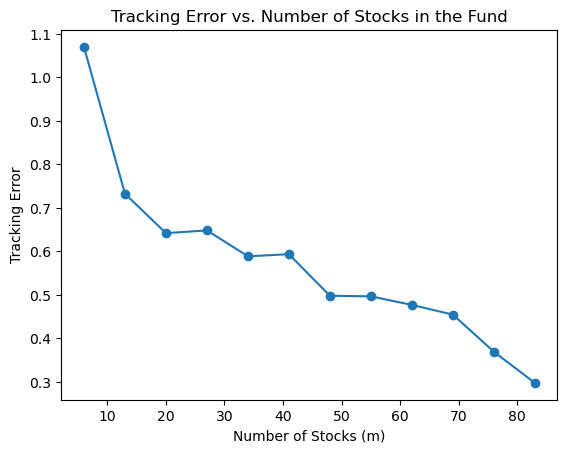

In [352]:
import matplotlib.pyplot as plt

tracking_errors = []
m_values = range(6, 90, 7) 

for m in m_values:
    selected_stocks = stock_selection(similarity_matrix, m)
    weights = calculate_weights(selected_stocks, stock_returns_2024, ndx_returns_2024)
    tracking_error = evaluate_performance(weights, selected_stocks, stock_returns_2024, ndx_returns_2024)
    tracking_errors.append(tracking_error)

# Plot tracking error vs. number of stocks
plt.plot(m_values, tracking_errors, marker='o')
plt.xlabel("Number of Stocks (m)")
plt.ylabel("Tracking Error")
plt.title("Tracking Error vs. Number of Stocks in the Fund")
plt.show()


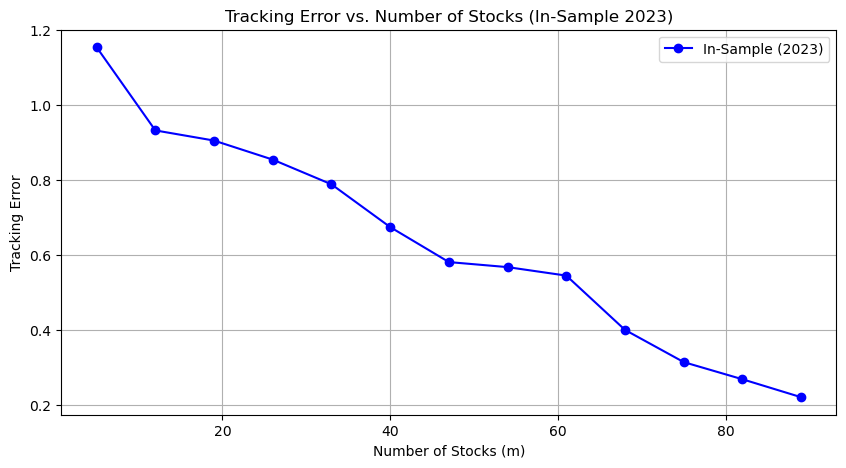

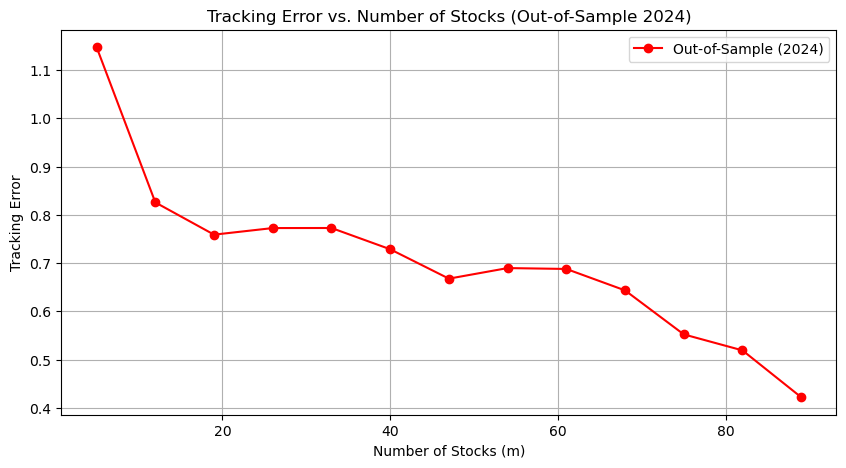

In [358]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store tracking errors for in-sample (2023) and out-of-sample (2024)
tracking_errors_in_sample = []
tracking_errors_out_sample = []
m_values = range(5, 90, 7)

for m in m_values:
    # In-sample (2023)
    selected_stocks = stock_selection(similarity_matrix, m)
    weights = calculate_weights(selected_stocks, stock_returns_2023, ndx_returns_2023)
    tracking_error_2023 = evaluate_performance(weights, selected_stocks, stock_returns_2023, ndx_returns_2023)
    tracking_errors_in_sample.append(tracking_error_2023)
    
    # Out-of-sample (2024)
    # Use selected stocks and weights from 2023 to calculate tracking error in 2024
    selected_stock_returns_2024 = stock_returns_2024.iloc[:, selected_stocks]  # Select columns based on selected stock indices
    portfolio_returns_2024 = selected_stock_returns_2024.dot(weights)  # Calculate portfolio returns using 2023 weights
    tracking_error_2024 = np.sum(np.abs(ndx_returns_2024 - portfolio_returns_2024))  # Calculate out-of-sample tracking error
    tracking_errors_out_sample.append(tracking_error_2024)

# Plotting In-Sample (2023) Tracking Error
plt.figure(figsize=(10, 5))
plt.plot(m_values, tracking_errors_in_sample, marker='o', color='blue', label="In-Sample (2023)")
plt.xlabel("Number of Stocks (m)")
plt.ylabel("Tracking Error")
plt.title("Tracking Error vs. Number of Stocks (In-Sample 2023)")
plt.legend()
plt.grid(True)
plt.show()

# Plotting Out-of-Sample (2024) Tracking Error
plt.figure(figsize=(10, 5))
plt.plot(m_values, tracking_errors_out_sample, marker='o', color='red', label="Out-of-Sample (2024)")
plt.xlabel("Number of Stocks (m)")
plt.ylabel("Tracking Error")
plt.title("Tracking Error vs. Number of Stocks (Out-of-Sample 2024)")
plt.legend()
plt.grid(True)
plt.show()